# Requirements

In [109]:
import os,sys

import numpy as np

import librosa
import librosa.display

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import trange
import librosa
import tqdm
from sklearn.model_selection import KFold

from datetime import datetime

import pathlib
import random

#### Used for listening to audio samples in ipynb

In [110]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

# Setting Path variables

In [111]:
base_path = pathlib.Path('D:/전재원졸업연구/music-discern/Datasets/')

#Urbansound is nested in Datasets/Urbansound8K/audio/fold**
#Urbansound is already separated into batches, which need to be preserved.
urban_metadata_path = pathlib.Path(base_path/'Urbansound8K/metadata')
urban_audio_folders_path = pathlib.Path(base_path/'Urbansound8K/audio')
urban_audio_path_list = [x for x in urban_audio_folders_path.iterdir()][1:] #remove .DS_Store

#Jamendo is nested in Datasets/MTGJamendo/audio
#Jamendo is not separated in batches, so we need to separate it into 10 batches, matching urbansound.
jamendo_metadata_path = pathlib.Path(base_path/'MTGJamendo/metadata')
jamendo_audio_path = pathlib.Path(base_path/'MTGJamendo/audio')

#for later -> add a path for any .wav file that I want to observe.
test_subjects_path = pathlib.Path("./")


# Loading and Checking audio/metadata files

### Metadata

In [112]:
print(sorted(urban_metadata_path.glob("*")))
print(sorted(jamendo_metadata_path.glob("*")))

[WindowsPath('D:/전재원졸업연구/music-discern/Datasets/Urbansound8K/metadata/.DS_Store'), WindowsPath('D:/전재원졸업연구/music-discern/Datasets/Urbansound8K/metadata/UrbanSound8K.csv')]
[WindowsPath('D:/전재원졸업연구/music-discern/Datasets/MTGJamendo/metadata/raw_30s_cleantags.tsv')]


In [113]:
urban_tags = pd.read_csv(sorted(urban_metadata_path.glob('*'))[1])
urban_tags.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [114]:
#jamendo_tags = pd.read_csv(sorted(jamendo_metadata_path.glob('*'))[0], sep="\t")
#cannot be read in this way, need a special script given by MTG-jamendo on Github
import csv
from collections import defaultdict

CATEGORIES = ['genre', 'instrument', 'mood/theme']
TAG_HYPHEN = '---'
METADATA_DESCRIPTION = 'TSV file with such columns: TRACK_ID, ARTIST_ID, ALBUM_ID, PATH, DURATION, TAGS'

def get_id(value):
    return int(value.split('_')[1])

def get_length(values):
    return len(str(max(values)))

def read_file(tsv_file):
    tracks = {}
    tags = defaultdict(dict)

    # For statistics
    artist_ids = set()
    albums_ids = set()

    with open(tsv_file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)  # skip header
        for row in reader:
            track_id = get_id(row[0])
            tracks[track_id] = {
                'id': track_id,
                'artist_id': get_id(row[1]),
                'album_id': get_id(row[2]),
                'path': row[3],
                'duration': float(row[4]),
                'tags': row[5:],  # raw tags, not sure if will be used
            }
            tracks[track_id].update({category: set() for category in CATEGORIES})

            artist_ids.add(get_id(row[1]))
            albums_ids.add(get_id(row[2]))

            for tag_str in row[5:]:
                category, tag = tag_str.split(TAG_HYPHEN)

                if tag not in tags[category]:
                    tags[category][tag] = set()

                tags[category][tag].add(track_id)

                if category not in tracks[track_id]:
                    tracks[track_id][category] = set()

                tracks[track_id][category].update(set(tag.split(",")))

    print("Reading: {} tracks, {} albums, {} artists".format(len(tracks), len(albums_ids), len(artist_ids)))

    extra = {
        'track_id_length': get_length(tracks.keys()),
        'artist_id_length': get_length(artist_ids),
        'album_id_length': get_length(albums_ids)
    }
    return tracks, tags, extra

(tracks,_,_) = read_file(sorted(jamendo_metadata_path.glob('*'))[0])

Reading: 55701 tracks, 11280 albums, 3573 artists


In [115]:
jamendo_tags = pd.DataFrame.from_dict(tracks,orient='index')
jamendo_tags.head()

,id,artist_id,album_id,path,duration,tags,genre,instrument,mood/theme
214,214,14,31,14/214.mp3,124.6,[genre---punkrock],{punkrock},{},{}
215,215,14,31,15/215.mp3,151.4,[genre---metal],{metal},{},{}
216,216,14,31,16/216.mp3,234.9,[genre---metal],{metal},{},{}
217,217,14,31,17/217.mp3,127.9,[genre---punkrock],{punkrock},{},{}
218,218,14,31,18/218.mp3,180.7,[genre---punkrock],{punkrock},{},{}


In [116]:
# Take a sample from both urban and jamendo;

urban_sample_path = urban_audio_path_list[random.randrange(0,len(urban_audio_path_list))]
urban_sample_path = sorted(urban_sample_path.glob('*.wav'))
urban_sample_path = urban_sample_path[random.randrange(0,len(urban_sample_path))]

jamendo_sample_path = sorted(jamendo_audio_path.glob('*.mp3'))
jamendo_sample_path = jamendo_sample_path[random.randrange(0,len(jamendo_sample_path))]

# without ffmpeg on windows, librosa cannot load .mp3 files. (NoBackendError), download manual at https://www.geeksforgeeks.org/how-to-install-ffmpeg-on-windows/ 
urban_sample,urban_sr = librosa.load(str(urban_sample_path), res_type='kaiser_fast')
jamendo_sample,jamendo_sr = librosa.load(str(jamendo_sample_path),res_type='kaiser_fast')

print(urban_sample.shape)
print(jamendo_sample.shape)


c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(88200,)
(3670965,)


['car_horn']
[{'chillout', 'acidjazz', 'funk'}]


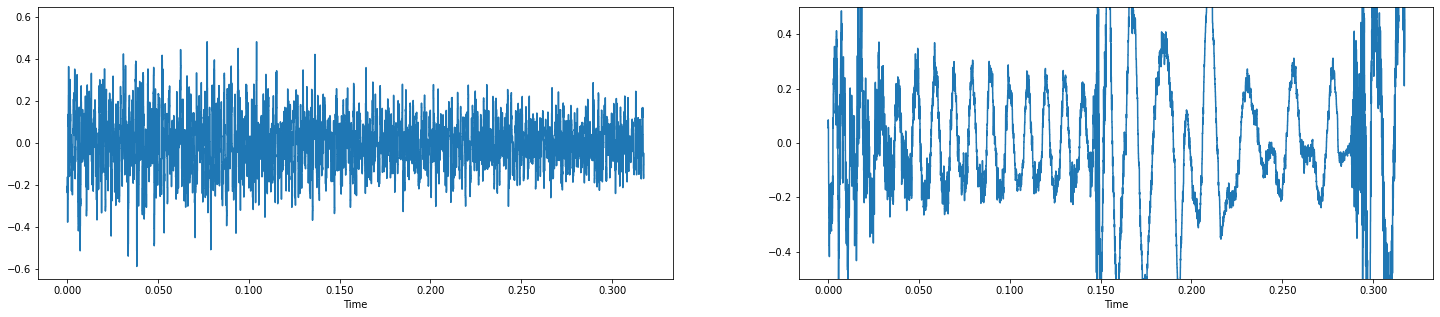

In [117]:
plt.figure(figsize=(25, 5))
plt.title('Waveform of Urbansound8K sample & MTG-Jamendo sample (in order)')
temp_phase_shift_jam = 100000
temp_phase_shift_urban = 0
temp_sample_len = 7000

plt.subplot(1, 2, 1)
librosa.display.waveshow(urban_sample[temp_phase_shift_urban:temp_sample_len+temp_phase_shift_urban])
plt.subplot(1, 2, 2)
librosa.display.waveshow(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam])
#librosa 0.9 changes waveplot -> waveshow. 

plt.ylim(-0.5, 0.5)
jamendo_id = str(jamendo_sample_path).split('\\')[-1][:-4]
urban_id = str(urban_sample_path).split('\\')[-1][:]

print(urban_tags[urban_tags['slice_file_name']==urban_id]['class'].to_numpy())
print(jamendo_tags[jamendo_tags['id']==int(jamendo_id)]['genre'].to_numpy())

In [118]:
#Listen to Waveform 1
Audio(urban_sample[temp_phase_shift_urban:temp_sample_len+temp_phase_shift_urban],urban_sr)

In [119]:
#Listen to Waveform 2
Audio(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam],jamendo_sr)

### Audio

# Setting Preprocessing variables
    We will make a complex array of size (513,345) (best possible resolution)
    513 = n_fft//2 + 1 => n_fft = 1024
    345 = ceil(signal_length / hop_length) => hop_length = n_fft // 4 (?) = 256 , signal_length = 88200? 

### Find the optimal signal length for slicing

In [123]:
# Testing the length distribution of each dataset, to find the optimal signal length for slicing.
n_data_urban = urban_tags.shape[0]
list_of_times_urban = np.array([])
n_data_jam = jamendo_tags.shape[0]
jam_id_list = jamendo_tags['id'].to_numpy()
list_of_times_jam = np.array([])


# Create histogram for urban
for i in trange(n_data_urban):
    #the sample rates are different for each, so this procedure is necessary.
    temp_fold_template = pathlib.Path("fold"+str(urban_tags['fold'][i]))
    temp_filepath = pathlib.Path(urban_audio_folders_path/temp_fold_template/urban_tags['slice_file_name'][i])
    temp_time_pressure_array,sr = librosa.load(temp_filepath, res_type='kaiser_fast')
    list_of_times_urban = np.append(list_of_times_urban,[len(temp_time_pressure_array)])

for i in trange(n_data_jam):
    list_of_times_jam = np.append(list_of_times_jam,[jamendo_tags['duration'][jam_id_list[i]]*22050])


100%|██████████| 55701/55701 [00:01<00:00, 39665.61it/s]


In [124]:
list_of_times_urban

array([ 7002., 88200., 88200., ..., 77307., 55787., 55787.])

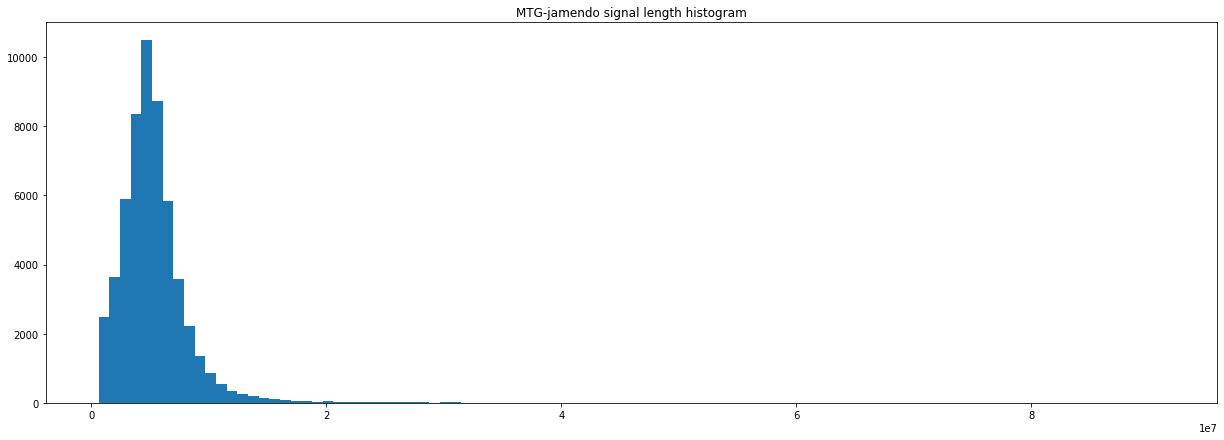

In [125]:
plt.figure(figsize=(21, 7))
plt.title('MTG-jamendo signal length histogram')
_ = plt.hist(list_of_times_jam,bins=100)

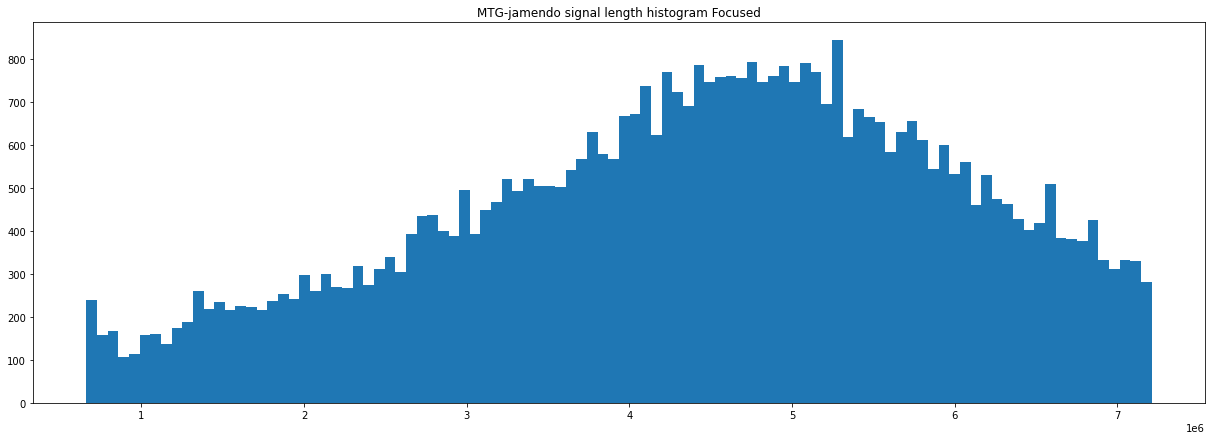

In [126]:
list_of_times_jam_refocused = sorted(list_of_times_jam)[:-len(list_of_times_jam)//6]

plt.figure(figsize=(21, 7))
plt.title('MTG-jamendo signal length histogram Focused')
_ = plt.hist(list_of_times_jam_refocused,bins=100)

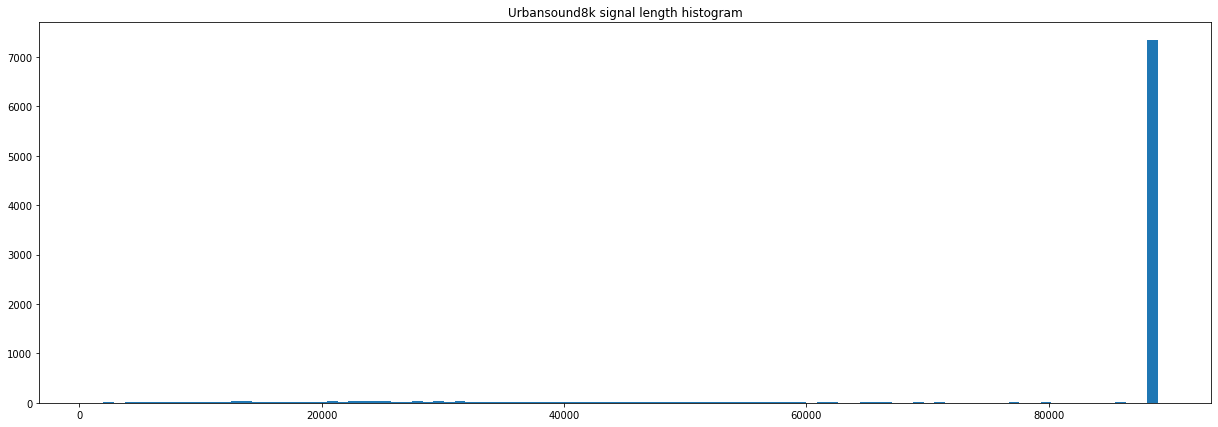

In [127]:
plt.figure(figsize=(21, 7))
plt.title('Urbansound8k signal length histogram')
_ = plt.hist(list_of_times_urban,bins=100)

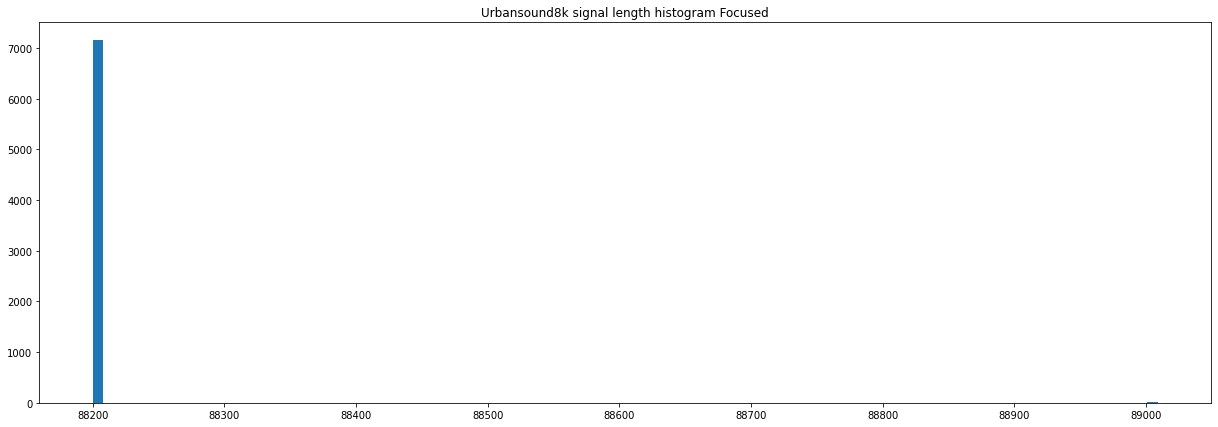

In [135]:
list_of_times_urban_refocused = sorted(list_of_times_urban)[int(len(list_of_times_urban)*0.18):-1]

plt.figure(figsize=(21, 7))
plt.title('Urbansound8k signal length histogram Focused')
_ = plt.hist(list_of_times_urban_refocused,bins=100)

### Setting parameters accordingly

In [139]:
n_fft = 1024
hop_length = n_fft//4 #256
sr = 22050
signal_length = 88200

n_data_urban = urban_tags.shape[0]
n_data_jam = jamendo_tags.shape[0]
jam_id_list = jamendo_tags['id'].to_numpy()

In [ ]:
# 2 ways of doing this
    # 1. find the average rms or pick any rms, then normalize all the .wav, .mp3 files
    # 2. normalize the spectrogram image
# 1 is computationaly expensive, so #2.
def normalize_audio(signal):
    normalized_signal = ""
    return normalized_signal

In [153]:
def split_and_sample(signal,sr,save_file_path):
    #split the signal
    if len(signal) < signal_length:
        return False
    else:
        temp_sliced_list = []
        temp_for_slicing = signal
        while len(temp_for_slicing) >= signal_length:
            temp_sliced_list.append(temp_for_slicing[:signal_length])
            temp_for_slicing=temp_for_slicing[signal_length:]
            assert len(temp_sliced_list[-1]) == signal_length
    for k in range(len(temp_sliced_list)):
        #stft
        temp_X = librosa.stft(temp_sliced_list[k],n_fft=n_fft,hop_length=hop_length)
        #save the images with proper recognizable names
        # return temp_X #testmode
        np.save(  pathlib.Path(  str(save_file_path)+"_"+str(k)+".npy"  ),temp_X,allow_pickle=True)
    

### Test out if STFT works properly

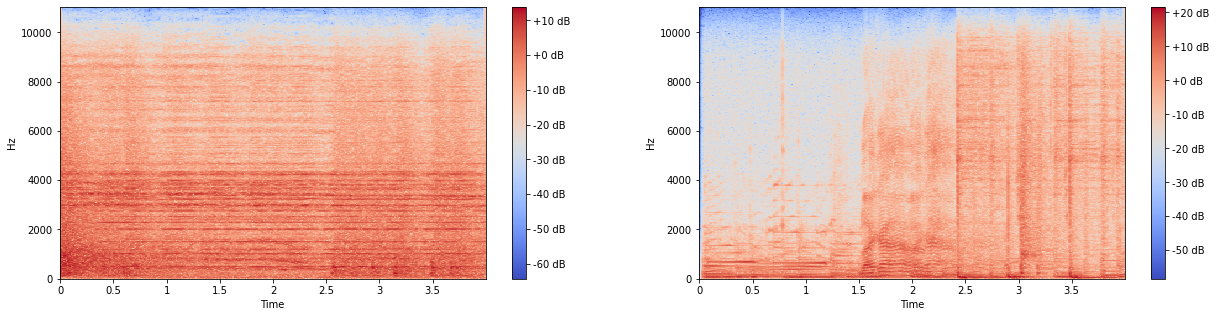

In [145]:
processed_urban_sample = librosa.power_to_db(abs( split_and_sample(urban_sample,sr,"") ))
processed_jam_sample = librosa.power_to_db(abs( split_and_sample(jamendo_sample,sr,"") ))

plt.figure(figsize=(21, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(processed_urban_sample, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(processed_jam_sample, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

# Preprocessing & Saving

In [155]:
#Urbansound8K
for i in trange(n_data_urban):
    temp_fold_template = pathlib.Path("fold"+str(urban_tags['fold'][i]))
    temp_filepath = pathlib.Path(urban_audio_folders_path/temp_fold_template/urban_tags['slice_file_name'][i])
    temp_time_pressure_array,sr = librosa.load(temp_filepath, res_type='kaiser_fast')
    save_file_path = pathlib.Path(str(base_path)+"/Urbansound8K/processed/"+str(temp_fold_template)+"/"+str(urban_tags['slice_file_name'][i])[:-4])
    split_and_sample(temp_time_pressure_array,sr,save_file_path)

100%|██████████| 8732/8732 [13:54<00:00, 10.46it/s]


In [156]:
#MTG-Jamendo
count = 0
for i in trange(n_data_jam):
    #must check whether the file exists in the dataset or not.
    temp_filepath = pathlib.Path(str(jamendo_audio_path)+'/'+str(jam_id_list[i])+".mp3")
    if temp_filepath.exists():
        temp_time_pressure_array,sr = librosa.load(temp_filepath, res_type='kaiser_fast')
        save_file_path = pathlib.Path(str(base_path)+"/MTGJamendo/processed/"+ "fold" + str(count%10 + 1) + '/' + str(jam_id_list[i]) )
        count += 1
        split_and_sample(temp_time_pressure_array,sr,save_file_path)
print(count)

  0%|          | 0/55701 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
100%|██████████| 55701/55701 [29:40<00:00, 31.28it/s]  

586
